In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter
import polars as pl

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior-stride-segment"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png', 'eps'):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 


In [2]:
def load_ior_summary_list(json_file: Path):
    try:
        # print(json_file)
        data = json.loads(json_file.read_text())
        return [
            {
                'Version': data['Version'],
                'Began': data['Began'],
                'Command line': data['Command line'],
                'Machine': data['Machine'],
                'Finished': data['Finished'],
                **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
                # **{f"max_{k}": v for k, v in test["max"].items()},
                **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
                **{f"Options_{k}": v for k, v in test["Options"].items()},
                **{f'summary_{k}': v for k, v in data['summary'][index].items()},
                **{f'result_{k}': v for k, v in result.items()},
                # 'iorIteration': iteration,
            }
            for index, test in enumerate(data['tests'])
            for result in test["Results"]
            # for iteration, results in enumerate(test["Results"]) # iteration ?
            # for result in results
        ]
    except Exception as e:
        print(f"Failed to load {json_file}, {e}")
        return []

In [3]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [4]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

# fmt: off
job_group = (
    ("ior-strided-pmembb/2024.10.04-16.45.37-default", {}),
)
# fmt: on

re_timestamp = re.compile(
    r"([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})"
)


def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None


re_runid = re.compile(r"_([0-9]+)\.json")


def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None


def load_job_params(job_dir: Path, runid: int):
    try:
        return json.loads((job_dir / f"job_params_{runid}.json").read_text())
    except Exception as e:
        print(f"Failed to load job_params{runid}.json, {e}")
        return {}


df_src = (
    pl.DataFrame(
        [
            {
                **default_metadata,
                "job_start": parse_job_start_timestamp(job_dir),
                **load_job_params(job_dir, get_runid(ior_summary_file)),
                **ior_summary,
                **metadata,
            }
            for job_group_dir, metadata in job_group
            for job_dir in (RAW_BASEDIR / job_group_dir).glob("*")
            if job_dir.is_dir()
            for ior_summary_file in job_dir.glob("ior_summary_*.json")
            for ior_summary in load_ior_summary_list(ior_summary_file)
        ]
    )
    .with_columns(
        odirect=pl.col("Command line").str.contains("--posix.odirect"),
        strided=pl.col("summary_transferSize") == pl.col("summary_blockSize"),
    )
    .rename(
        {
            "summary_bwMaxMIB": "bw",
            "summary_MeanTime": "time",
            "summary_segmentCount": "segmentCount",
            "summary_blockSize": "blockSize",
            "summary_transferSize": "transferSize",
            "summary_operation": "operation",
            "Parameters_filePerProc": "fpp",
            "Parameters_reorderTasks": "reorder",
            "summary_API": "api",
            "result_access": "access",
            "result_bwMiB": "bwMiB",
            "result_openTime": "openTime",
            "result_wrRdTime": "wrRdTime",
            "result_closeTime": "closeTime",
            "result_totalTime": "totalTime",
        }
    )
    .with_columns(
        fpp=pl.col("fpp").cast(pl.Boolean),
        reorder=pl.col("reorder").cast(pl.Boolean),
        bwGB=pl.col("bwMiB") * 2**20 / 10**9,
    )
    .with_columns(
        pl.when((pl.col("storageSystem") == "PEANUTS") & (pl.col("spack_env_name") == "mpiio-pmembb"))
        .then(True)
        .otherwise(False)
        .alias("aggread"),
    )
    .sort("nnodes", "access")
)

In [5]:
(
    df_src
    .select(
        "storageSystem",
        "aggread",
        "nnodes",
        "ppn",
        "access",
        "segmentCount",
        "blockSize",
        "transferSize",
        "bwGB",
    )
)

storageSystem,aggread,nnodes,ppn,access,segmentCount,blockSize,transferSize,bwGB
str,bool,i64,i64,str,i64,i64,i64,f64
"""PEANUTS""",true,1,8,"""read""",1,536870912,2097152,26.869556
"""PEANUTS""",true,1,8,"""read""",1,536870912,2097152,26.831457
"""PEANUTS""",false,1,8,"""read""",1,536870912,2097152,27.810684
"""PEANUTS""",false,1,8,"""read""",1,536870912,2097152,27.952225
"""PEANUTS""",false,1,8,"""write""",131072,4096,4096,8.162762
…,…,…,…,…,…,…,…,…
"""PEANUTS""",false,64,8,"""read""",1,536870912,2097152,315.48859
"""PEANUTS""",true,64,8,"""read""",1,536870912,2097152,625.699213
"""PEANUTS""",true,64,8,"""read""",1,536870912,2097152,1051.362993


nnodes,+Aggregate_read,Baseline
i64,f64,f64
2,61.762099,20.418238
4,82.042961,27.519358
8,156.223273,51.494556
16,272.792503,96.596028
32,497.541685,186.952564
64,1051.362993,315.48859


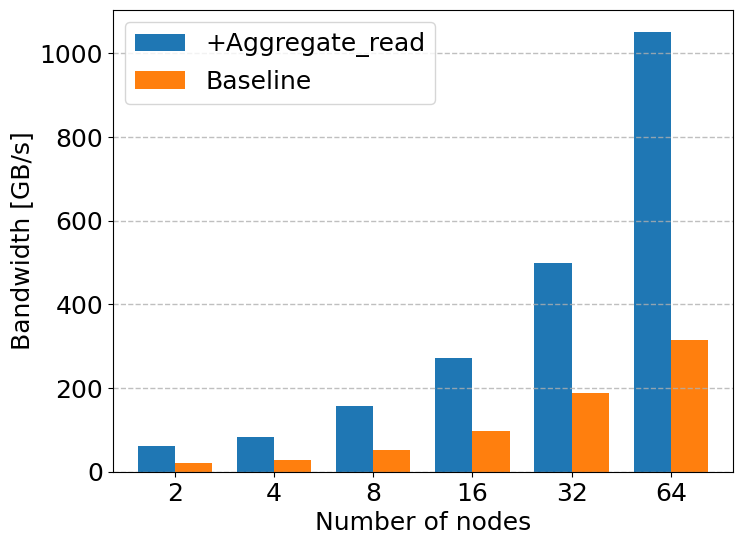

In [6]:
plt.rcParams.update({'font.size': 18})

group_by_columns = [
    # "storageSystem",
    "aggread",
    "nnodes",
    # "ppn",
    # "access",
]

df = (
    df_src
    .filter(
        pl.col("access") == "read",
        pl.col("storageSystem") == "PEANUTS",
        pl.col("nnodes") > 1,
    )
    .group_by(group_by_columns)
    .agg(pl.max("bwGB"))
    .with_columns(
        pl.when(pl.col("aggread"))
        .then(pl.lit("+Aggregate_read"))
        .otherwise(pl.lit("Baseline"))
        .alias("legend")
    )
    # .with_columns(
    #     pl.co
    # )
    .sort("nnodes")
)
# display(df)

fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
fig.patch.set_alpha(1)
(
    df
    .pivot(values="bwGB", index="nnodes", on="legend")
    .pipe(lambda df: (display(df), df)[-1])
    .to_pandas()
    .set_index("nnodes")
    .plot(
        ax=axes,
        kind="bar",
        xlabel="Number of nodes",
        ylabel="Bandwidth [GB/s]",
        rot=0,
        width=0.75,
    )
)
axes.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
plt.show()